1. Setup and Data Generation:
This creates folders, installs libraries, and generates synthetic supply chain data (demand history, supplier performance, distances).

In [1]:
# === Section 1: Setup & Synthetic Data ===

import os, sys, subprocess
import pandas as pd
import numpy as np

project_root = "/content/supplychain-ai-optimizer"
dirs = ["src", "data", "app", "reports"]
for d in dirs:
    os.makedirs(f"{project_root}/{d}", exist_ok=True)

# --- Demand data ---
np.random.seed(42)
days = pd.date_range("2024-01-01", periods=365, freq="D")
base_demand = 200 + 20*np.sin(np.arange(365)/365*2*np.pi*3)  # seasonality
noise = np.random.normal(0, 15, size=365)
promo = (np.random.rand(365) < 0.08).astype(int)             # occasional promotions
demand = np.maximum(5, (base_demand + noise + promo*40).round()).astype(int)

demand_df = pd.DataFrame({"date": days, "sku": "WIDGET-A", "demand": demand, "promo": promo})

# --- Network data ---
plants = ["Plant_North","Plant_South"]
dcs    = ["DC_East","DC_Central","DC_West"]
stores = [f"Store_{i+1}" for i in range(5)]

def rand_dist(n, m, low=50, high=800):
    return pd.DataFrame(np.random.randint(low, high, size=(n,m)))

plant_to_dc = rand_dist(len(plants), len(dcs)); plant_to_dc.columns = dcs; plant_to_dc.insert(0, "from", plants)
dc_to_store = rand_dist(len(dcs), len(stores)); dc_to_store.columns = stores; dc_to_store.insert(0, "from", dcs)

supplier_perf = pd.DataFrame({
    "supplier": ["SupplierAlpha","SupplierBeta","SupplierGamma"],
    "on_time_rate": [0.96, 0.91, 0.88],
    "defect_rate": [0.01, 0.015, 0.02],
    "avg_lead_time_days": [7,9,11],
    "cost_index": [1.0, 0.93, 0.9],
})

# --- Save datasets ---
demand_df.to_csv(f"{project_root}/data/demand_history.csv", index=False)
plant_to_dc.to_csv(f"{project_root}/data/plant_to_dc_distances.csv", index=False)
dc_to_store.to_csv(f"{project_root}/data/dc_to_store_distances.csv", index=False)
supplier_perf.to_csv(f"{project_root}/data/supplier_performance.csv", index=False)

print("✅ Data generated and saved!")


✅ Data generated and saved!


2. Demand Forecasting (AI Model):
Random Forest regression on past demand to predict future demand.

In [2]:
# === Section 2: Demand Forecasting ===

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

def make_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date")
    df["dayofweek"] = df["date"].dt.dayofweek
    df["month"] = df["date"].dt.month
    for l in [1,7,14,28]:
        df[f"lag_{l}"] = df["demand"].shift(l)
    df["roll7"] = df["demand"].shift(1).rolling(7).mean()
    df["roll28"] = df["demand"].shift(1).rolling(28).mean()
    return df.dropna()

def train_forecaster(data_path="supplychain-ai-optimizer/data/demand_history.csv"):
    df = pd.read_csv(data_path)
    df_feat = make_features(df)
    X = df_feat.drop(columns=["date","sku","demand"])
    y = df_feat["demand"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return model, mape, df

def forecast_horizon(model, df: pd.DataFrame, horizon=14):
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    preds = []
    last_known = df.iloc[-1]["demand"]
    hist = df.copy()
    for _ in range(horizon):
        d = hist["date"].max() + pd.Timedelta(days=1)
        new = {"date": d, "sku": "WIDGET-A", "demand": last_known, "promo": 0}
        hist = pd.concat([hist, pd.DataFrame([new])], ignore_index=True)
        feat = make_features(hist).iloc[[-1]]
        yhat = model.predict(feat.drop(columns=["date","sku","demand"])).item()
        preds.append({"date": d, "forecast": max(0, yhat)})
        last_known = yhat
    return pd.DataFrame(preds)

# Run forecasting
model, mape, df_hist = train_forecaster(f"{project_root}/data/demand_history.csv")
future_fc = forecast_horizon(model, df_hist, horizon=14)

print("✅ Forecast complete | MAPE:", round(mape,3))
print(future_fc.head())


✅ Forecast complete | MAPE: 0.067
        date  forecast
0 2024-12-31   207.545
1 2025-01-01   198.855
2 2025-01-02   211.135
3 2025-01-03   209.810
4 2025-01-04   199.345


3. Inventory Policy (ROP, EOQ):
Compute when to reorder and how much to order.


In [3]:
# === Section 3: Inventory Policy ===
import math

def z_value(service_level: float) -> float:
    from scipy.stats import norm
    return norm.ppf(service_level)

def safety_stock(std_demand, lead_time, service=0.95):
    return z_value(service) * std_demand * math.sqrt(lead_time)

def reorder_point(avg_demand, lead_time, std_demand, service=0.95):
    return avg_demand*lead_time + safety_stock(std_demand, lead_time, service)

def eoq(annual_demand, order_cost, holding_cost):
    return math.sqrt((2*annual_demand*order_cost) / max(1e-9, holding_cost))

# Compute values
avg_daily = df_hist["demand"].tail(28).mean()
std_daily = df_hist["demand"].tail(28).std()
annual_demand = df_hist["demand"].sum()

ROP = reorder_point(avg_daily, lead_time=5, std_demand=std_daily, service=0.95)
EOQ = eoq(annual_demand, order_cost=200, holding_cost=3.0)

print(f"✅ ROP: {ROP:.1f} units | EOQ: {EOQ:.1f} units/order")


✅ ROP: 1014.0 units | EOQ: 3140.6 units/order


4. Transportation Optimization:
Plan shipments from DCs → Stores with a greedy cost minimization.

In [4]:
# === Section 4: Transportation Optimization ===

dc_costs = pd.read_csv(f"{project_root}/data/dc_to_store_distances.csv").set_index("from")
costs = dc_costs * 0.5  # $0.5/km

def greedy_transport(costs, supply, demand):
    cost_mat = costs.values.astype(float)
    sol = np.zeros_like(cost_mat)
    candidates = [(cost_mat[i,j], i, j) for i in range(cost_mat.shape[0]) for j in range(cost_mat.shape[1])]
    candidates.sort(key=lambda x: x[0])
    supplies, demands = supply.copy(), demand.copy()
    for _, i, j in candidates:
        if supplies[i] <= 0 or demands[j] <= 0: continue
        qty = min(supplies[i], demands[j])
        sol[i,j] = qty
        supplies[i] -= qty; demands[j] -= qty
    return pd.DataFrame(sol, index=costs.index, columns=costs.columns)

total_forecast = int(future_fc["forecast"].sum())
supply = pd.Series([total_forecast//3]*3, index=dc_costs.index)
supply.iloc[0] += total_forecast - supply.sum()
demand = pd.Series([int(max(50, total_forecast/5 + (i-2)*20)) for i in range(len(dc_costs.columns))], index=dc_costs.columns)

solution = greedy_transport(costs, supply.values, demand.values)
total_cost = (solution * costs).to_numpy().sum()

print("✅ Transport Plan:")
print(solution)
print("Total Cost: $", round(total_cost,2))


✅ Transport Plan:
            Store_1  Store_2  Store_3  Store_4  Store_5
from                                                   
DC_East       549.0      0.0      0.0      0.0    432.0
DC_Central      0.0      0.0    589.0    393.0      0.0
DC_West         0.0    569.0      0.0    216.0    197.0
Total Cost: $ 421459.5


5. Create synthetic data (plants/DCs/stores + distances + demand)

In [11]:
# --- A1: Data setup for LP optimization ---
import numpy as np, pandas as pd, os

np.random.seed(42)
project_root = "/content/supplychain-ai-lp"
os.makedirs(project_root, exist_ok=True)

# Network: 3 DCs -> 5 Stores (distances in km)
dcs    = ["DC_East","DC_Central","DC_West"]
stores = [f"Store_{i+1}" for i in range(5)]

dist = pd.DataFrame(np.random.randint(50, 800, size=(len(dcs), len(stores))), index=dcs, columns=stores)
dist.to_csv(f"{project_root}/dc_to_store_distances.csv")

# Demand (units needed at each store)
base = 800
demand = pd.Series([base + (i-2)*50 for i in range(len(stores))], index=stores).clip(lower=200)
demand.to_csv(f"{project_root}/store_demand.csv")

# Supply at DCs (units available)
total_demand = int(demand.sum())
supply_vals = [total_demand//len(dcs)]*len(dcs)
supply_vals[0] += total_demand - sum(supply_vals)  # fix rounding
supply = pd.Series(supply_vals, index=dcs)
supply.to_csv(f"{project_root}/dc_supply.csv")

print("✅ Data written to:", project_root)
print("Distances (km):\n", dist.head(), "\n")
print("Demand (units):\n", demand, "\n")
print("Supply (units):\n", supply)


✅ Data written to: /content/supplychain-ai-lp
Distances (km):
             Store_1  Store_2  Store_3  Store_4  Store_5
DC_East         152      485      320      156      121
DC_Central      750       70      664      171      516
DC_West         264      380      508      137      422 

Demand (units):
 Store_1    700
Store_2    750
Store_3    800
Store_4    850
Store_5    900
dtype: int64 

Supply (units):
 DC_East       1334
DC_Central    1333
DC_West       1333
dtype: int64


6.  Install PuLP and solve min-cost transport (with optional emissions budget/closures)

In [13]:
# --- A2: LP solve (min-cost transport with optional CO2 budget + DC closures) ---
!pip -q install pulp

import pandas as pd, pulp

project_root = "/content/supplychain-ai-lp"
dist = pd.read_csv(f"{project_root}/dc_to_store_distances.csv", index_col=0)
demand = pd.read_csv(f"{project_root}/store_demand.csv", index_col=0).iloc[:, 0]
supply = pd.read_csv(f"{project_root}/dc_supply.csv", index_col=0).iloc[:, 0]

# ---- Parameters you can tweak ----
cost_per_km_per_truck = 0.5     # $
kg_co2_per_km_per_truck = 120.0 # kg
truck_capacity_units = 1000.0   # units per truck
use_emission_budget = True
emission_budget_kg = 50_000.0
closed_dcs = []                 # e.g., ["DC_West"] to simulate outage
# ----------------------------------

dc_index = dist.index.tolist()
store_index = dist.columns.tolist()

# Apply closures
eff_supply = supply.astype(float).copy()
for dc in closed_dcs:
    if dc in eff_supply.index: eff_supply.loc[dc] = 0.0

# Per-unit cost/emission
per_unit_cost = dist * (cost_per_km_per_truck / truck_capacity_units)
per_unit_emission = dist * (kg_co2_per_km_per_truck / truck_capacity_units)

# LP
prob = pulp.LpProblem("dc_to_store_min_cost", pulp.LpMinimize)
x = pulp.LpVariable.dicts("x", ((i,j) for i in dc_index for j in store_index), lowBound=0)

# Objective
prob += pulp.lpSum(per_unit_cost.loc[i,j] * x[(i,j)] for i in dc_index for j in store_index)

# Supply constraints
for i in dc_index:
    prob += pulp.lpSum(x[(i,j)] for j in store_index) <= float(eff_supply.loc[i])

# Demand constraints
for j in store_index:
    prob += pulp.lpSum(x[(i,j)] for i in dc_index) >= float(demand.loc[j])

# Emissions budget (optional)
if use_emission_budget:
    prob += pulp.lpSum(per_unit_emission.loc[i,j] * x[(i,j)] for i in dc_index for j in store_index) <= emission_budget_kg

_ = prob.solve(pulp.PULP_CBC_CMD(msg=False))

# Solution
sol = pd.DataFrame(0.0, index=dc_index, columns=store_index)
for i in dc_index:
    for j in store_index:
        val = x[(i,j)].value()
        sol.loc[i,j] = 0.0 if val is None else val

total_cost = float((sol * per_unit_cost).to_numpy().sum())
total_emissions = float((sol * per_unit_emission).to_numpy().sum())

print("✅ LP status:", pulp.LpStatus[prob.status])
print("\nShipment plan (units):\n", sol)
print("\nTotal cost: $", round(total_cost, 2))
print("Total CO₂:  ", round(total_emissions, 2), "kg")
print("Units shipped:", int(sol.values.sum()))


✅ LP status: Infeasible

Shipment plan (units):
             Store_1  Store_2  Store_3  Store_4  Store_5
DC_East      -366.0      0.0    800.0      0.0    900.0
DC_Central      0.0    750.0      0.0      0.0      0.0
DC_West      1066.0      0.0      0.0    850.0      0.0

Total cost: $ 379.82
Total CO₂:   91157.04 kg
Units shipped: 4000


7. LSTM Forecasting (deep learning time-series demand predictor)

In [14]:
# --- B1: Demand time series (synthetic) ---
import numpy as np, pandas as pd, os

np.random.seed(42)
project_root = "/content/supplychain-ai-lstm"
os.makedirs(project_root, exist_ok=True)

days = pd.date_range("2024-01-01", periods=365, freq="D")
base = 200 + 20*np.sin(np.linspace(0, 6*np.pi, len(days)))   # multi-seasonality-ish
promo = (np.random.rand(len(days)) < 0.1).astype(int) * 40
noise = np.random.normal(0, 12, size=len(days))
demand = np.maximum(5, (base + promo + noise).round()).astype(int)

df = pd.DataFrame({"date": days, "sku": "WIDGET-A", "demand": demand})
df.to_csv(f"{project_root}/demand_history.csv", index=False)
df.tail()


,date,sku,demand
360,2024-12-26,WIDGET-A,184
361,2024-12-27,WIDGET-A,203
362,2024-12-28,WIDGET-A,188
363,2024-12-29,WIDGET-A,197
364,2024-12-30,WIDGET-A,200


In [ ]:
8. Install TensorFlow + Train LSTM + Forecast N days

In [16]:
# --- B2: LSTM forecaster (train + forecast) ---
# Colab usually has TF preinstalled; pin is optional:
import tensorflow as tf
print("✅ TensorFlow version:", tf.__version__)

import numpy as np, pandas as pd
from tensorflow import keras

data_path = "/content/supplychain-ai-lstm/demand_history.csv"
window = 28     # lookback days
horizon = 14    # forecast days
epochs = 25
batch_size = 32

df = pd.read_csv(data_path)
y = df["demand"].astype(float).values
mu, sigma = y.mean(), y.std()
ys = (y - mu) / (sigma + 1e-8)

def make_supervised(series, window, horizon):
    X, Y = [], []
    for i in range(len(series) - window - horizon + 1):
        X.append(series[i:i+window])
        Y.append(series[i+window:i+window+horizon])
    X = np.array(X)[..., None]
    Y = np.array(Y)
    return X, Y

X, Y = make_supervised(ys, window, horizon)
split = int(0.8 * len(X))
Xtr, Ytr, Xval, Yval = X[:split], Y[:split], X[split:], Y[split:]

model = keras.Sequential([
    keras.layers.Input(shape=(window,1)),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(horizon)
])
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mae")
hist = model.fit(Xtr, Ytr, validation_data=(Xval, Yval), epochs=epochs, batch_size=batch_size, verbose=0)

# Forecast next horizon days
last_window = ys[-window:].reshape(1, window, 1)
yhat_s = model.predict(last_window, verbose=0)[0]
yhat = yhat_s * (sigma + 1e-8) + mu

start = pd.to_datetime(df["date"]).max() + pd.Timedelta(days=1)
fc_dates = pd.date_range(start, periods=horizon, freq="D")
fc = pd.DataFrame({"date": fc_dates, "forecast": np.maximum(0, yhat)})

# Simple validation metric (1-step naive MAPE over validation slice)
def mape(a,b):
    import numpy as np
    a, b = np.array(a), np.array(b)
    return np.mean(np.abs((a-b)/np.maximum(1e-8,np.abs(a))))

naive = Yval[:,0]  # compare only 1st step of horizon vs naive = last historical point
pred1 = model.predict(Xval, verbose=0)[:,0]
val_mape = mape(Yval[:,0]*(sigma+1e-8)+mu, pred1*(sigma+1e-8)+mu)

print("✅ LSTM trained")
print("Validation (1-step) MAPE:", f"{val_mape:.3f}")
print("\nNext", horizon, "days forecast:")
print(fc)


✅ TensorFlow version: 2.19.0
✅ LSTM trained
Validation (1-step) MAPE: 0.083

Next 14 days forecast:
         date    forecast
0  2024-12-31  195.821578
1  2025-01-01  192.166973
2  2025-01-02  193.903293
3  2025-01-03  195.682578
4  2025-01-04  194.991096
5  2025-01-05  196.739281
6  2025-01-06  199.344818
7  2025-01-07  196.919388
8  2025-01-08  197.655445
9  2025-01-09  198.798198
10 2025-01-10  200.809143
11 2025-01-11  203.557427
12 2025-01-12  205.771610
13 2025-01-13  206.073798


9. Plot:
A blue line = historical daily demand (with seasonality, promos, noise).
An orange line = your model’s forecast for the next N days.
A vertical dashed line = where forecasting begins.


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


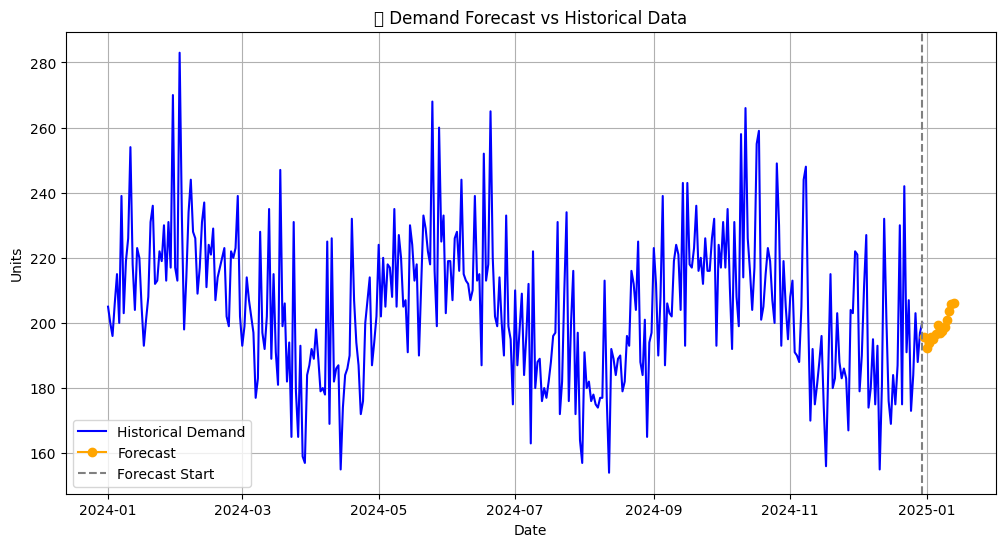

In [17]:
# --- Plot historical demand + forecast ---
import matplotlib.pyplot as plt

# Historical demand
plt.figure(figsize=(12,6))
plt.plot(pd.to_datetime(df["date"]), df["demand"], label="Historical Demand", color="blue")

# Forecast horizon
plt.plot(fc["date"], fc["forecast"], label="Forecast", color="orange", marker="o")

# Formatting
plt.axvline(pd.to_datetime(df["date"]).max(), color="gray", linestyle="--", label="Forecast Start")
plt.title("📈 Demand Forecast vs Historical Data")
plt.xlabel("Date")
plt.ylabel("Units")
plt.legend()
plt.grid(True)
plt.show()


10. Forecast vs. Historical + Validation Errors:

1)Forecast vs Historical Demand
Blue line = past daily demand.
Orange line = predicted demand for the next horizon.
Gray dashed line = where forecasting begins.

2)Validation Error Plot
Blue line = actual demand from the validation slice.
Orange line = LSTM’s predicted demand.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


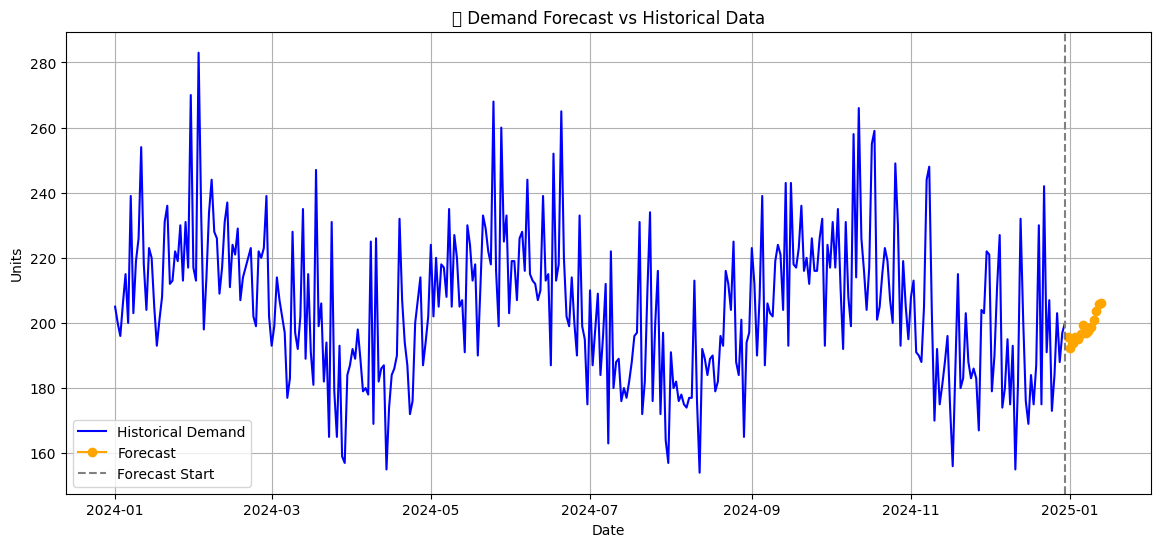

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


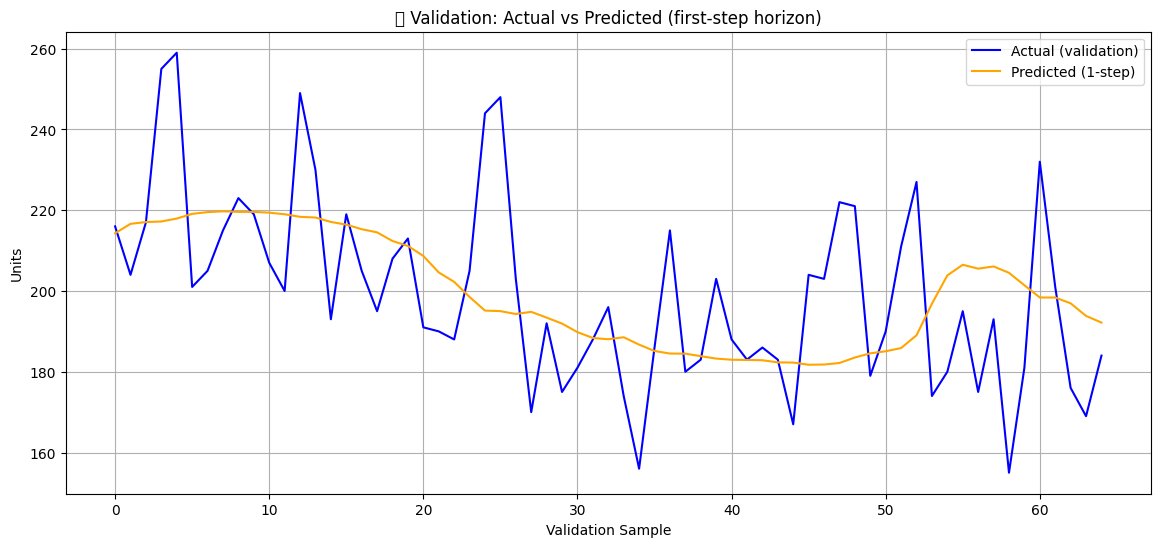

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- 1. Forecast vs Historical ---
plt.figure(figsize=(14,6))
plt.plot(pd.to_datetime(df["date"]), df["demand"], label="Historical Demand", color="blue")
plt.plot(fc["date"], fc["forecast"], label="Forecast", color="orange", marker="o")
plt.axvline(pd.to_datetime(df["date"]).max(), color="gray", linestyle="--", label="Forecast Start")
plt.title("📈 Demand Forecast vs Historical Data")
plt.xlabel("Date")
plt.ylabel("Units")
plt.legend()
plt.grid(True)
plt.show()

# --- 2. Validation Errors (how good was the model?) ---
# Compare the first-step predictions in validation set vs actual demand
pred_val = model.predict(Xval, verbose=0)[:,0] * (sigma + 1e-8) + mu
true_val = Yval[:,0] * (sigma + 1e-8) + mu

plt.figure(figsize=(14,6))
plt.plot(range(len(true_val)), true_val, label="Actual (validation)", color="blue")
plt.plot(range(len(pred_val)), pred_val, label="Predicted (1-step)", color="orange")
plt.title("📊 Validation: Actual vs Predicted (first-step horizon)")
plt.xlabel("Validation Sample")
plt.ylabel("Units")
plt.legend()
plt.grid(True)
plt.show()
